# CSE255 HW2
# Mengqi Yu
# A53077101
# My ticker is 'PEP'

In [1]:
import sys,os
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

from time import time
import math
import pandas as pd
from glob import glob
import pickle

from sklearn.decomposition import PCA
from operator import itemgetter

In [2]:
Data_dir='/Users/yumengqi/Documents/cse255/2_PCA/spdata_csv/'
Work_dir='/Users/yumengqi/Documents/cse255/2_PCA/'
curr_dir=os.getcwd()
curr_dir
%cd $Work_dir

/Users/yumengqi/Documents/cse255/2_PCA


In [3]:
# load data
PD=pickle.load(open('DailyDiffs.pkl','rb'))

##Global analysis
The following code is used to count how many sector there are and assign each one a color

In [4]:
filename='constituents.csv'
tbl=pd.read_csv(filename,index_col='Symbol',parse_dates=True)
tbl=tbl.sort_index()
tbl_name=tbl['Name']
tbl_sector=tbl['Sector']
colorArr = ['b','g', 'r', 'c', 'm', 'y', 'k', '#D2691E', '#00CED1', '#696969']

colorSet = {}
name2Sec = {}
cnt = 0
for index, row in tbl.iterrows():
    sec = row['Sector']
    name2Sec[index] = sec
    if not(sec in colorSet):
        colorSet[sec] = colorArr[cnt]
        cnt = cnt + 1
print 'There are '+str(cnt)+' sectors'

There are 10 sectors


The code in the following cell uses the information in the file constituents.csv to color code the stocks according to sector to which the stock belongs. The result is shown in the figure below.

(481, 13422)


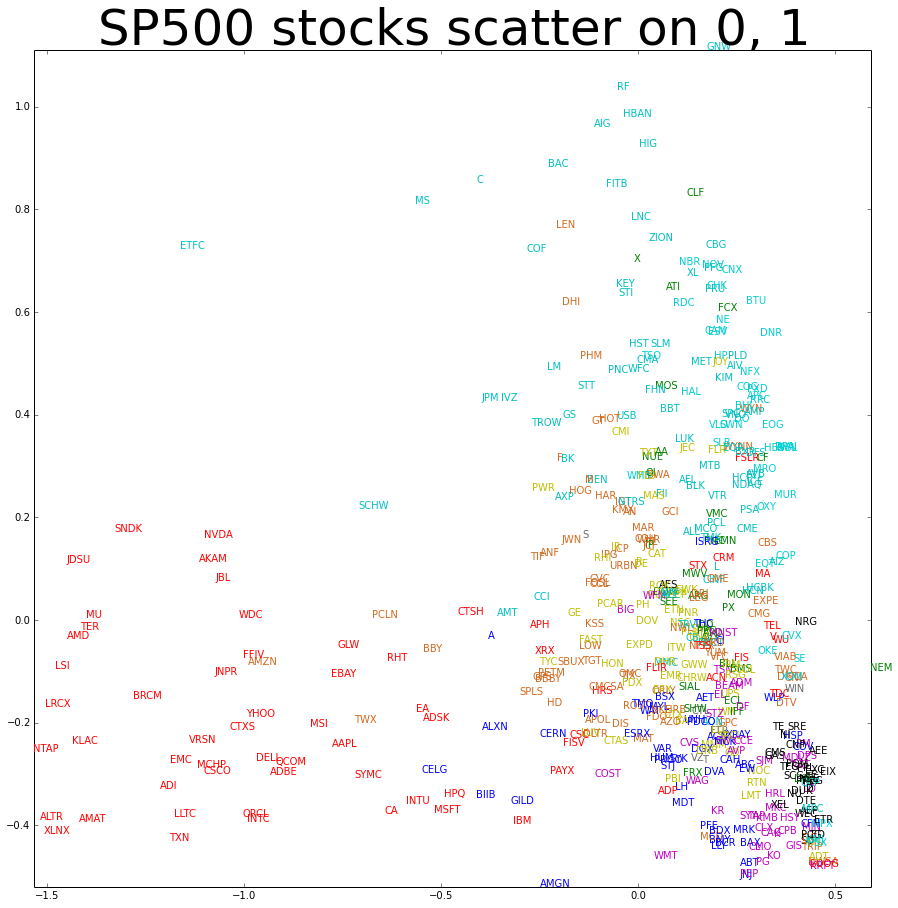

In [5]:
from sklearn.decomposition import PCA
Daily=PD['Daily']
Diffs=PD['Diffs']

pca = PCA(n_components=21)
my_diffs_matrix=np.transpose(np.array(Diffs.fillna(0)))
print np.shape(my_diffs_matrix)

pca.fit(my_diffs_matrix)
eigen_vecs=pca.components_
np.shape(eigen_vecs)

tdf = pca.transform(my_diffs_matrix)  # compute the projections of the stocks on the eigen-values
np.shape(tdf)

# Generate the scatter plot of the stocks on a pair of eigen-vectors defined by i0,i1
i0=0;i1=1
fig, ax = plt.subplots(figsize=(15, 15))  # In order that the stock ticker names are readable we make the plot very large
plt.xlim([np.amin(tdf[:,i0]),np.amax(tdf[:,i0])])
plt.ylim([np.amin(tdf[:,i1]),np.amax(tdf[:,i1])])
plt.title('SP500 stocks scatter on '+str(i0)+', '+str(i1),fontsize=50)
names=Diffs.columns
for i in range(len(names)):
    ax.annotate(names[i], (tdf[i,i0],tdf[i,i1]),fontsize=10, color=colorSet[name2Sec[names[i]]])

In [6]:
# find the last day's index in that year
idxArr = []
tmpArr = []
flagArr = [False, False, False, False, False]
idx = 0
cnt = 197
for index, row in Diffs.iterrows():
#     print index
    if str(index)[:9] == str(cnt)+'1-01-0' and not flagArr[cnt-197]:
        cnt = cnt + 1
        idxArr.append(idx-1)
#         tmpArr.append(index)
#         print idx-1
    idx = idx + 1
    
print idxArr
# print tmpArr


[2239, 4764, 7294, 9821, 12342]


In [7]:
### Averaging vectors
class run_aver:
    ## Initialize the object
    def __init__(self,alpha=0.0):
        self.t = 0.0
        self.s = None
        self.alpha = alpha

    def send(self,x):
        if self.t==0:
            self.s=x
        elif self.alpha==0:
            self.s=(x + self.t*self.s)/(self.t+1.0)
        else:
            self.s=self.alpha*x + (1-self.alpha)*self.s                           
        self.t+=1.0
        residual=x-self.s
        return residual
    
    def get_state(self):
        return self.s

    def get_sqrt(self):
        return math.sqrt(self.s)  # only for the case that the dimension is 1

In [24]:
### Finding Eigen-Vectors
# first initilize the self.s as a uniform unit vector
class run_Eigen:
    ## Initialize the object
    def __init__(self,alpha=0.0,beta=0.01):
        self.t = 0.0
        self.var = run_aver(alpha=0.01) # for estimating the 
        self.alpha=alpha
        self.beta=beta
        self.bst=250 #boost rate
        s=[1.0]*481
        self.s=s/LA.norm(s)
#         print LA.norm(self.s)
        
    def send(self,x):
        s=self.s
        if self.alpha==0:
            s=s+(np.dot(s,x)*self.beta/math.sqrt(self.t))*x
        else:
            temp=(np.dot(s,x)*self.alpha)*x*self.bst
            s=s+temp
        Norm=LA.norm(s)
        if math.isnan(Norm):
            print 'Norm is nan'
        if Norm>0: 
            s=s/Norm
            self.s=s
        #else do not update
        
        self.t+=1.0
        
        dot=np.dot(self.s,x)
        self.var.send(dot*dot)
        residual=x-dot*self.s
        return residual
    
    def get_state(self):
        return self.s
    
    def get_var(self):
        return self.var.get_state()

In [25]:
diffs_matrix=np.transpose(my_diffs_matrix)
print np.shape(diffs_matrix)
sz=len(diffs_matrix)
print sz

(13422, 481)
13422


In [29]:
kk=21 # number of eigen-vectors to search for.

# The modeling pipeline
Av=run_aver(alpha=0)  # find the mean
Eig=[run_Eigen(alpha=1.0/2500,beta=0.1) for i in range(kk)] # find the first kk eigen-vectors

# Compute the errors 
err=[run_aver(alpha=0) for i in range(kk+2)] # compute the average length of the residual.
L=[np.zeros(sz) for i in range(kk+2)]

### A convinience function to perform a single update single update
def one_step(x,i):
    err[0].send(np.dot(x,x))
    L[0][i]=err[0].get_sqrt()
    r1=Av.send(x)
    err[1].send(np.dot(r1,r1))
    L[1][i]=err[1].get_sqrt()/L[0][i]
    r2=r1
    for j in range(kk):
        r2=Eig[j].send(r2)
        err[j+2].send(np.dot(r2,r2))
        L[j+2][i]=err[j+2].get_sqrt()/L[0][i]

In [30]:
StVecs=[]

for ii in range(10):
    for i in range(sz):
        x=diffs_matrix[i,:]
        one_step(x,i)
        Mean=Av.get_state()

for i in range(sz):
    x=diffs_matrix[i,:]
    one_step(x,i)
    Mean=Av.get_state()

    for k in idxArr:
        if k==i:
            print k
            tempVecs=np.zeros((kk, 481))
            for j in range(kk):
                tempVecs[j]=Eig[j].get_state()
            StVecs.append(tempVecs)

2239
4764
7294
9821
12342


The following 4 figures are the coloring tickers for the stocks in 1980,1990,2000,2010, respectively. We can see that some companies share the same sector form a cluster.<br>
Here I ignore 1970. This is because the data of PepsiCo(PEP) starts after 1970.<br>
I plot the figure on coordinate 1 and 2 instead of 0 and 1.<br>
The coordinate 0 has a very large variance, since there are lot of data with NAN value from the beginning to 1970 and they are filled with 0s. Thus, these dimensions count a lot in PCA and form the first eigen-vector. But this eigen-vector does not have much valuable information.

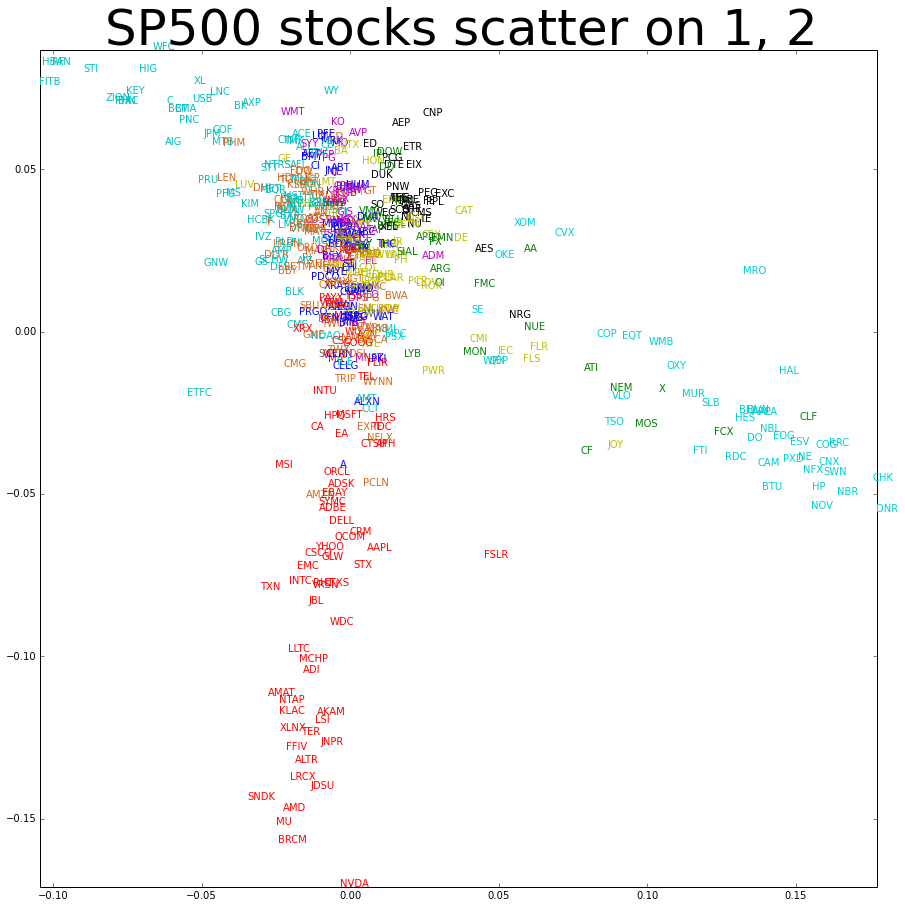

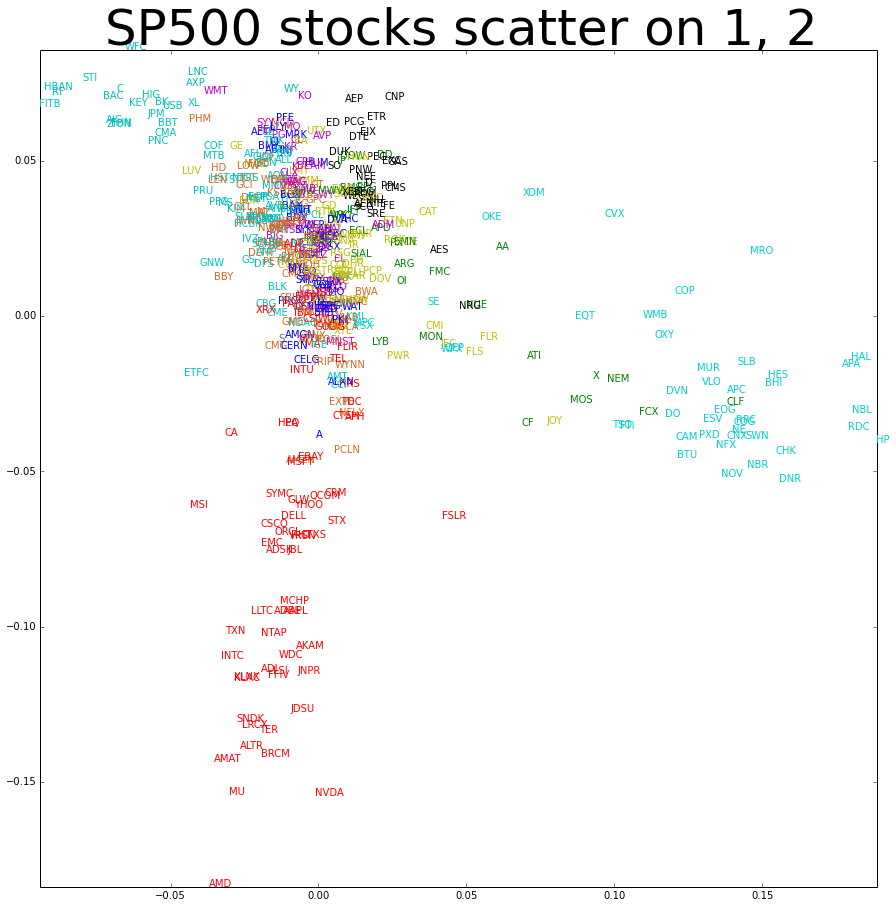

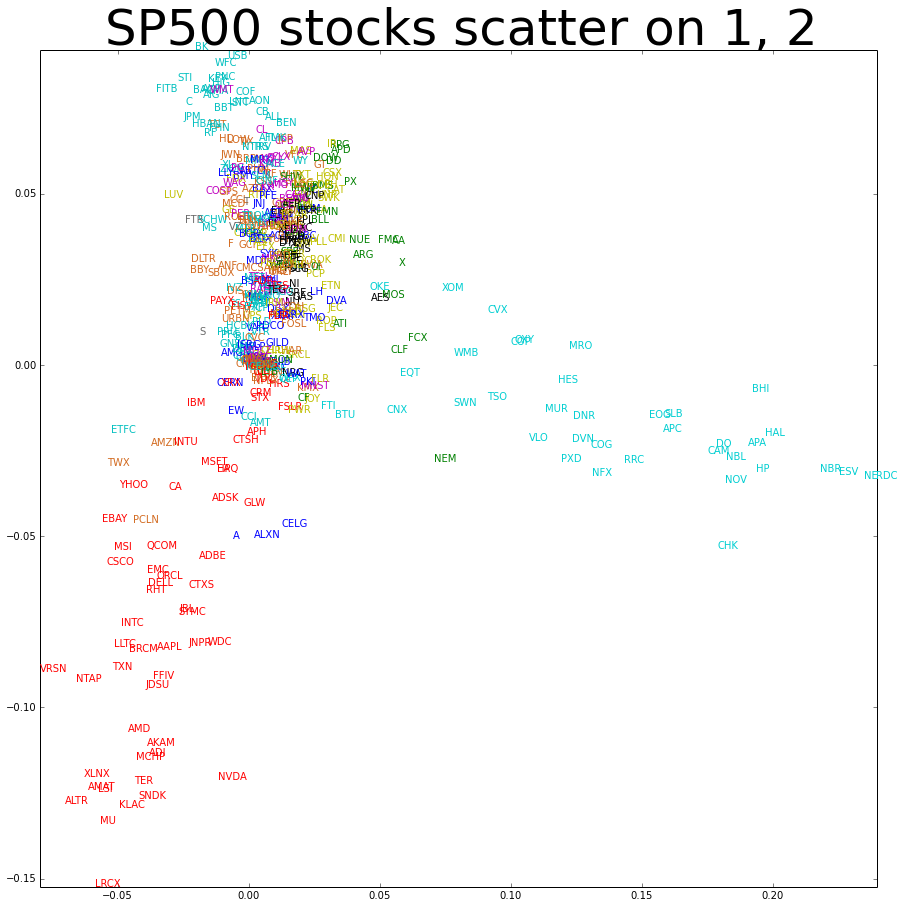

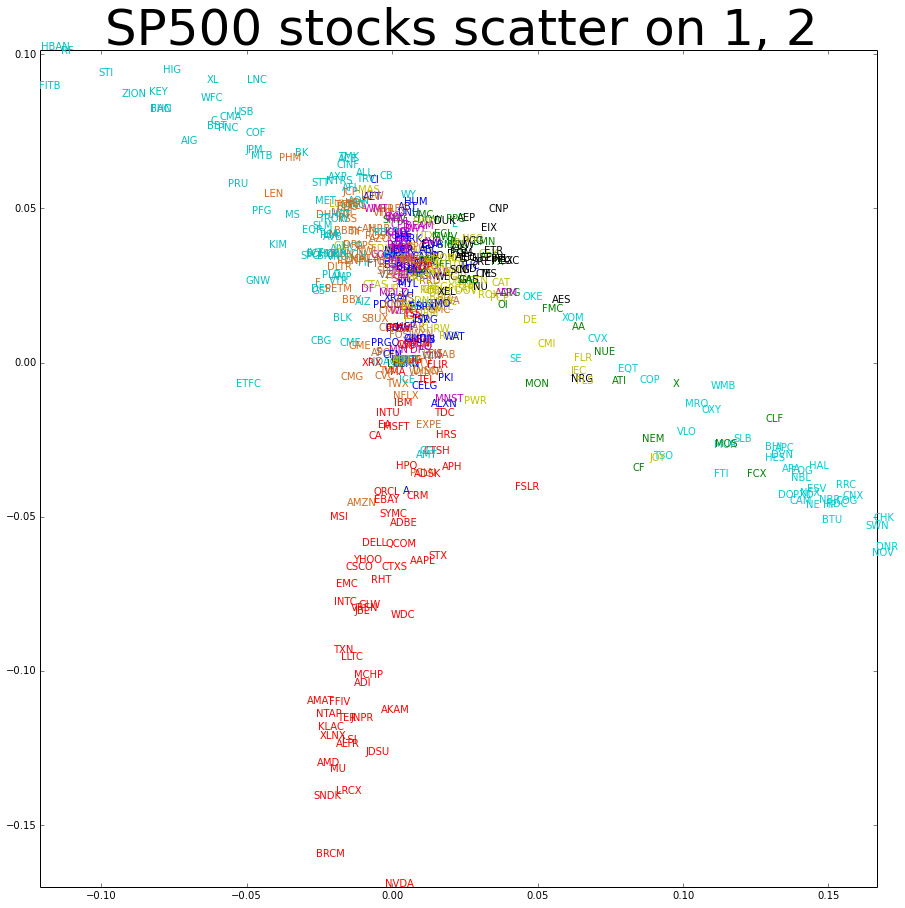

In [31]:
# i0=0;i1=1
i0=1;i1=2
names=Diffs.columns

for j in range(5):
    if j==0:
        continue
    vec = np.transpose(StVecs[j])
#     print np.shape(vec)
    fig, ax = plt.subplots(figsize=(15,15))  # In order that the stock ticker names are readable we make the plot very large
    plt.xlim([np.amin(vec[:,i0]),np.amax(vec[:,i0])])
    plt.ylim([np.amin(vec[:,i1]),np.amax(vec[:,i1])])
    plt.title('SP500 stocks scatter on '+str(i0)+', '+str(i1),fontsize=50)
    for i in range(len(names)):
        ax.annotate(names[i], (vec[i][i0],vec[i][i1]),fontsize=10, color=colorSet[name2Sec[names[i]]])
        

A helper function to find vec's nearest 10 vectors among a vector array.

In [19]:
def findNearest10(vecArr, vec):
    # each row is a vector
    vNum = np.shape(vecArr)[0]
#     print vNum
    distArr = []
    rtIdx = []
    for i in range(vNum):
        tmp = vecArr[i]-vec
#         print np.shape(tmp[1:21])
        distArr.append( (LA.norm(tmp[1:21]), i) )
#     print distArr
    sortArr = sorted(distArr, key=itemgetter(0))
#     print sortArr
    for i in range(10):
        rtIdx.append(sortArr[i+1][1])
#     print rtIdx
    return rtIdx 

def getIdxByName(name):
    for i in range(len(names)):
        if names[i] == name :
            return i

In [20]:
# find the index of PepsiCo
pepIdx = getIdxByName('PEP')
print pepIdx

384


The following code finds the "nearest" 10 companies based on the global PCA analysis results. I print out each company's ticker, full name and its sector.<br>
We find that most of these companies are highly related companies in the field of Comsumer Staples, Consumer Discretionary and Health Care. I will discuss the relations between these companies at the end of this notebook.

In [39]:
# print pca.explained_variance_ratio_ 
# print np.shape(tdf)
# print np.shape(tdf[pepIdx])
CorIdxArr = findNearest10(tdf, tdf[pepIdx])
# print CorIdxArr
print 'The following 10 companies are sorted by distance in ascending order'
print 'Ticker'.ljust(8)+'Name'.ljust(30)+'Sector'.ljust(20)
print '----------------------------------------------------------------------'
nameArr1 = []
for i in range(10):
    nameArr1.append(names[CorIdxArr[i]])
    curName=names[CorIdxArr[i]]
    print curName.ljust(8)+ tbl_name[curName].ljust(30)+ tbl_sector[curName].ljust(5)
# print nameArr1

The following 10 companies are sorted by distance in ascending order
Ticker  Name                          Sector              
----------------------------------------------------------------------
PG      Procter & Gamble              Consumer Staples
KO      Coca-Cola Co                  Consumer Staples
JNJ     Johnson & Johnson             Health Care
CL      Colgate-Palmolive             Consumer Staples
BMY     Bristol-Myers Squibb          Health Care
MO      Altria Group                  Consumer Staples
MRK     Merck & Co                    Health Care
LLY     Lilly (Eli)                   Health Care
MCD     McDonald's Corp               Consumer Discretionary
AVP     Avon Products                 Consumer Staples


The following figure shows the daily prices of PEP and its nearest 10 companies' stocks. From the figure, we can see that their stock prices are highly correlated and almost vary in the same way.<br>
The y coordinate is the price after applied logarithm.

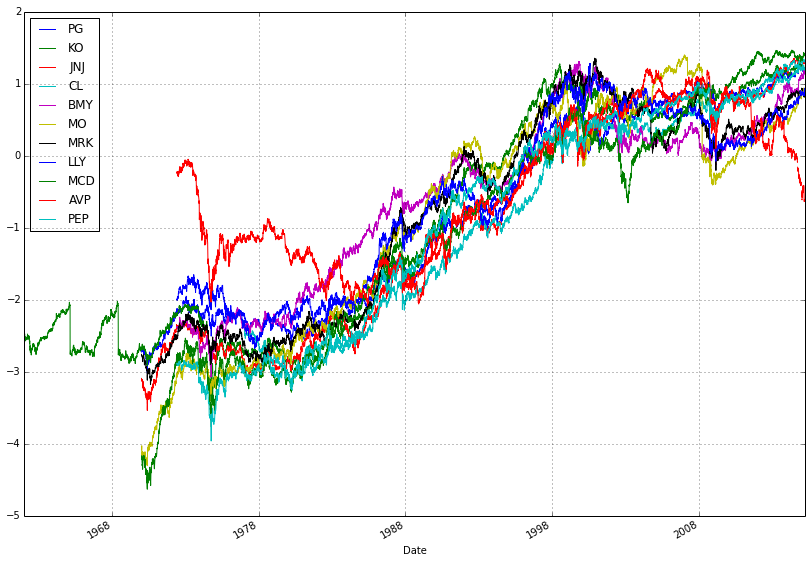

In [22]:
# plot some stocks
nameArr1.append('PEP')
np.log(Daily[nameArr1]).plot(figsize=(14,10))

The following results show the 10 nearest companies for 1980, 1990, 2000 and 2010. Most of these companies overlap the companies found by global PCA. We can find that most of these companies are highly related companies in the field of Comsumer Staples, Consumer Discretionary and Health Care. I will discuss the relations between these companies at the end of this notebook.

In [42]:
AllNameArr = []
print 'Ticker'.ljust(8)+'Name'.ljust(30)+'Sector'.ljust(20)
for j in range(5):
    if j==0:
        continue
    tmpNameArr = []
    print '-------------------------------------------------------'
    vecs = np.transpose(np.array( StVecs[j] )) #History[idxArr[j]]['V'] )
#     print np.shape(vecs)
#     pepvec = np.transpose(np.transpose( vecs )[pepIdx])
    pepvec = vecs[pepIdx, :]
#     print np.shape(pepvec)
    CorIdxArr = findNearest10(vecs, pepvec)
    for i in range(10):
        tmpNameArr.append( names[CorIdxArr[i]] )
        curName=names[CorIdxArr[i]]
        print curName.ljust(8)+ tbl_name[curName].ljust(30)+ tbl_sector[curName].ljust(5)
    AllNameArr.append(tmpNameArr)
#     print tmpNameArr
# print AllNameArr

Ticker  Name                          Sector              
-------------------------------------------------------
PG      Procter & Gamble              Consumer Staples
KO      Coca-Cola Co                  Consumer Staples
AVP     Avon Products                 Consumer Staples
JNJ     Johnson & Johnson             Health Care
CL      Colgate-Palmolive             Consumer Staples
LLY     Lilly (Eli)                   Health Care
MMM     3M Co                         Industrials
SYY     Sysco Corp                    Consumer Staples
BMY     Bristol-Myers Squibb          Health Care
XOM     Exxon Mobil                   Energy
-------------------------------------------------------
PG      Procter & Gamble              Consumer Staples
KO      Coca-Cola Co                  Consumer Staples
JNJ     Johnson & Johnson             Health Care
AVP     Avon Products                 Consumer Staples
CL      Colgate-Palmolive             Consumer Staples
LLY     Lilly (Eli)                   H

The following figure shows the daily prices of PEP and its nearest 10 companies' stocks in 1980, 1990, 2000 and 2010. From the figure, we can see that their stock prices are highly correlated and almost vary in the same way.
The y coordinate is the price after applied logarithm.

(4, 11)


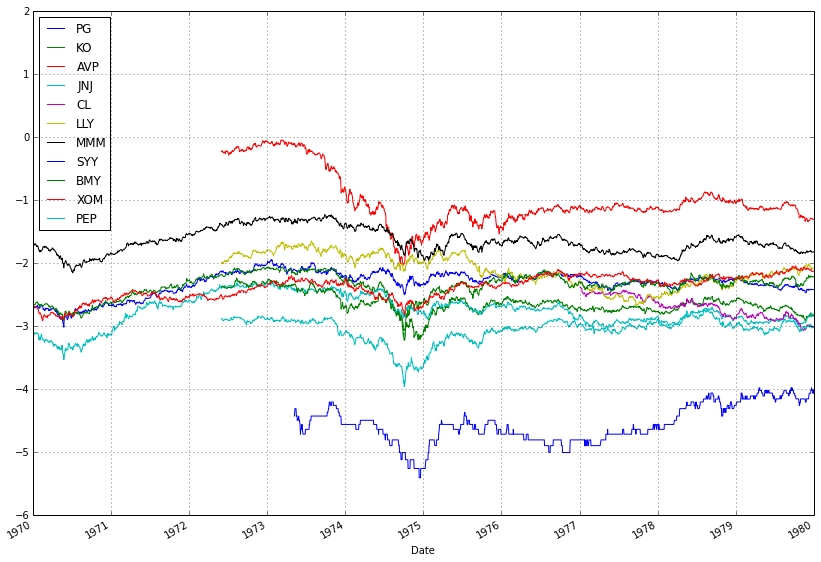

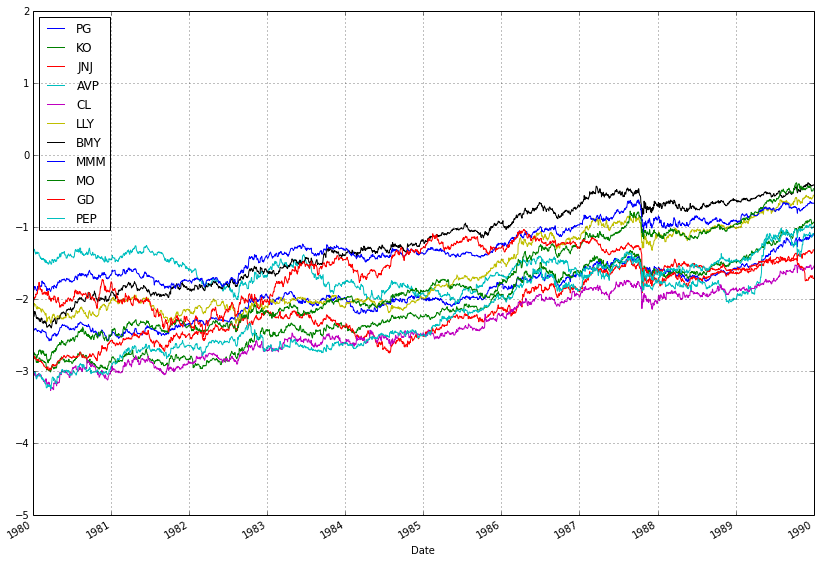

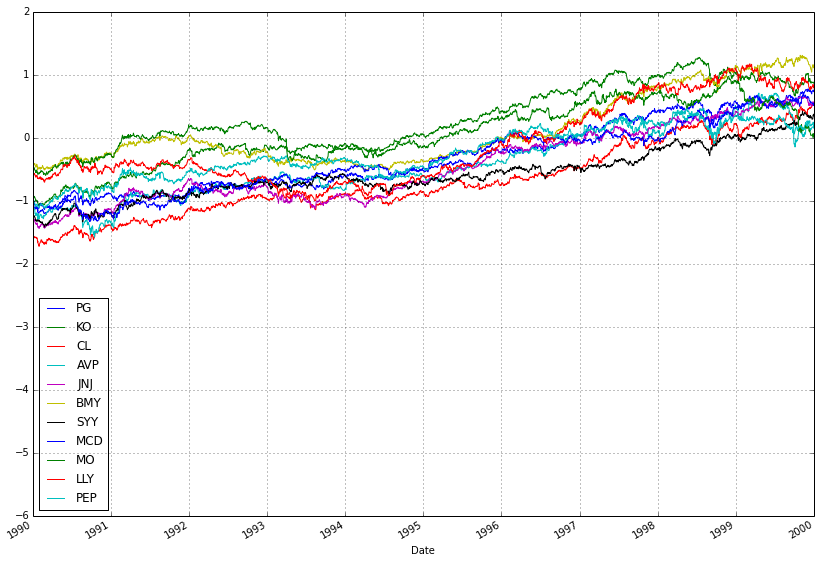

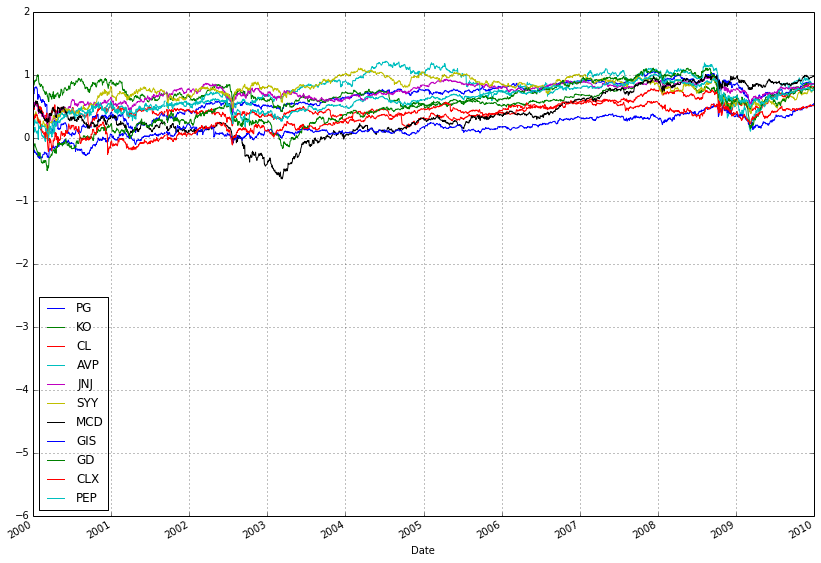

In [57]:
print np.shape(AllNameArr)
AllNameArr[0].append('PEP')
np.log(Daily[AllNameArr[0]]).plot(figsize=(14,10), xlim=('1970-01-01','1980-01-01'))
AllNameArr[1].append('PEP')
np.log(Daily[AllNameArr[1]]).plot(figsize=(14,10), xlim=('1980-01-01','1990-01-01'))
AllNameArr[2].append('PEP')
np.log(Daily[AllNameArr[2]]).plot(figsize=(14,10), xlim=('1990-01-01','2000-01-01'))
AllNameArr[3].append('PEP')
np.log(Daily[AllNameArr[3]]).plot(figsize=(14,10), xlim=('2000-01-01','2010-01-01'))

###Brief history of PepsiCo
Pepsi (stylized in lowercase as pepsi, formerly stylized in uppercase as PEPSI) is a carbonated soft drink that is produced and manufactured by PepsiCo. Created and developed in 1893 and introduced as Brad's Drink, it was renamed as Pepsi-Cola on August 28, 1898, then to Pepsi in 1961. In 1931, at the depth of the Great Depression, the Pepsi-Cola Company entered bankruptcy – in large part due to financial losses incurred by speculating on the wildly fluctuating sugar prices as a result of World War I. Assets were sold and Roy C. Megargel bought the Pepsi trademark. Megargel was unsuccessful, and soon Pepsi's assets were purchased by Charles Guth, the President of Loft, Inc.
On three separate occasions between 1922 and 1933, The Coca-Cola Company was offered the opportunity to purchase the Pepsi-Cola company, and it declined on each occasion.

The following are the brief description of the companies that appear in the global PCA or in the online PCA.

**PG: Procter & Gamble Co**
* The Procter & Gamble Company manufactures and markets consumer products in countries throughout the world. The Company provides products in the laundry and cleaning, paper, beauty care, food and beverage, and health care segments. Procter & Gamble's products are sold primarily through mass merchandisers, grocery stores, membership club stores, drug stores, and neighborhood stores.

**KO: Coca-Cola Co**
* The Coca-Cola Company manufactures, markets, and distributes soft drink concentrates and syrups. The Company also distributes and markets juice and juice-drink products. Coca-Cola distributes its products to retailers and wholesalers in the United States and internationally.

**JNJ: Johnson & Johnson**
* Johnson & Johnson manufactures health care products and provides related services for the consumer, pharmaceutical, and medical devices and diagnostics markets. The Company sells products such as skin and hair care products, acetaminophen products, pharmaceuticals, diagnostic equipment, and surgical equipment in countries located around the world.

**CL: Colgate-Palmolive Co**
* Colgate-Palmolive Company is a consumer products company that markets its products throughout the world. The Company's products include toothpaste, toothbrushes, shampoos, deodorants, bar and liquid soaps, dishwashing liquid, and laundry products, as well as pet nutrition products for cats and dogs.

**BMY: Bristol-Myers Squibb Co**
* Bristol-Myers Squibb Company is a global biopharmaceutical company. The Company develops, licenses, manufactures, markets, and sells pharmaceutical and nutritional products. Bristol-Myers Squibb products and experimental therapies address cancer, heart disease, HIV/AIDS, diabetes, rheumatoid arthritis, hepatitis, organ transplant rejection, and psychiatric disorders.

**MO: Altria Group Inc**
* Altria Group, Inc. is a holding company. The Company, through subsidiaries, manufactures and sells cigarettes and other tobacco products, including cigars and pipe tobacco. Altria holds an interest in a brewery company.

**MRK: Merck & Co Inc**
* Merck & Co., Inc. is a global health care company that delivers health solutions through its prescription medicines, vaccines, biologic therapies, animal health, and consumer care products, which it markets directly and through its joint ventures. The Company has operations in pharmaceutical, animal health, and consumer care.

**MLY: Eli Lilly & Co**
* Eli Lilly and Company discovers, develops, manufactures, and sells pharmaceutical products for humans and animals. The Company's products are sold in countries around the world. Eli Lilly's products include neuroscience products, endocrine products, anti-infectives, cardiovascular agents, oncology products, and animal health products.

**MCD: McDonald's Corp**
* McDonald's Corporation franchises and operates fast-food restaurants in the global restaurant industry. The Company's restaurants serve a variety of value-priced menu products in countries around the world.

**AVP: Avon Products Inc**
* Avon Products, Inc. manufactures and direct sells beauty and related products. The Company markets its products to consumers worldwide through independent sales representatives. Avon's product line includes beauty, fashion and home.

**LLY: Eli Lilly & Co**
* Eli Lilly and Company discovers, develops, manufactures, and sells pharmaceutical products for humans and animals. The Company's products are sold in countries around the world. Eli Lilly's products include neuroscience products, endocrine products, anti-infectives, cardiovascular agents, oncology products, and animal health products.

**MMM: 3M Co**
* 3M Co. conducts operations in electronics, telecommunications, industrial, consumer and office, health care, safety, and other markets. The Company's businesses share technologies, manufacturing operations, brands, marketing channels, and other resources. 3M serves customers in countries located around the world.

**SYY: Sysco Corp**
* Sysco Corporation distributes food and related products primarily to the foodservice industry. The Company also distributes personal care guest amenities, housekeeping supplies, room accessories, and textiles to the lodging industry.

**XOM: Exxon Mobil Corp**
* Exxon Mobil Corporation operates petroleum and petrochemicals businesses on a worldwide basis. The Company's operations include exploration and production of oil and gas, electric power generation, and coal and minerals operations. Exxon Mobil also manufactures and markets fuels, lubricants, and chemicals.

**GD: General Dynamics Corp**
* General Dynamics Corporation is a diversified defense company. The Company offers a broad portfolio of products and services in business aviation, combat vehicles, weapons systems and munitions, shipbuilding design and construction, and information systems, technologies and services.

**GIS: General Mills Inc**
* General Mills, Inc. manufactures and markets branded and packaged consumer foods worldwide. The Company also supplies branded and unbranded food products to the foodservice and commercial baking industries.

**CLX: Clorox Co**
* The Clorox Company produces and markets non-durable consumer products sold primarily through grocery and other retail stores. The Company's principal products include household cleaning and bleach products, charcoal, cat litter, automotive care products, dressings, and trash bags. Clorox markets its products in the United States and other countries around the world.


The following companies appears both in the global PCA and the online PCA, including PG, KO, JNJ, CL, BMY, MO, LLY, MCD and AVP. The times of occurence and the corresponding position are shown in the following table. For example, JNJ is the fourth, the third, the fifth and the fifth closest to PEP in 1980, 1990, 2000 and 2010 respectively. '-' means doesn't exist.

|Company Stock  |  Position of Occurences |
|:-------------:|:-----------------------:|
|PG  | 1,1,1,1 |
|KO  | 2,2,2,2 |
|JNJ | 4,3,5,5 |
|CL  | 5,5,3,3 |
|BMY | 9,7,6,- |
|MO  | -,9,9,- |
|LLY | 6,6,10,-|
|MCD | -,-,8,7 |
|AVP | 3,4,4,4 |

Coca-Cola Co (KO) is the competitor of PepsiCo (PEP). Procter & Gamble (PG), Avon Products (AVP), Colgate-Palmolive (CL) and Altria Group (MO) are all in the sector of Consumer Staples. And McDonald's Corp (MCD) is in Consumer Discretionary. I think they are related because all of them indicate how the market of consumer varies. Other companies like Johnson & Johnson (JNJ), Bristol-Myers Squibb (BMY) and Lilly Eli (LLY) are belong to sector Health Care. All of them produce something that people use everyday. Therefore, the stock prices of them act in a very similar way.